In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time

In [2]:
### Simulation Hyperparameters
# Room/Building
grid_rows = 20
grid_cols = 20
num_hazards = 5
num_hotspots = 2

# Initialize robot orientation (0: Up, 1: Right, 2: Down, 3: Left)
robot_orientation = 0
fov_radius = 5 # Define the field of view radius

# Simulation run parameters
num_steps = 500
time_per_step = 0.25 # Seconds per simulation step
memory_length = 20 # Keep track of the last 10 positions

In [3]:
### Simulation Functions & Setup
# Define grid dimensions for a single large room
grid = np.zeros((grid_rows, grid_cols), dtype=int)

# Place walls around the perimeter
grid[0, :] = 1
grid[-1, :] = 1
grid[:, 0] = 1
grid[:, -1] = 1

# Define target locations for mapping completion
target_locations = [(1, 1), (1, 18), (18, 1), (18, 18), (10, 10)]
locations_visited = [False] * len(target_locations)

# Define starting position at a doorway (adjacent to a wall)
start_pos = [18, 1] # Row 18, Col 1 - adjacent to the left wall
robot_pos = np.array(start_pos).reshape(2, 1)
robot_cov = np.eye(2) * 0.1
robot_path = [start_pos]

# Place random hazards and hotspots (away from the start)
hazards_locations = []
hotspots_locations = []
for _ in range(num_hazards):
    while True:
        row = random.randint(1, grid_rows - 2)
        col = random.randint(2, grid_cols - 2) # Avoid starting area
        if grid[row, col] == 0 and [col, row] != start_pos and (col, row) not in hazards_locations and (col, row) not in hotspots_locations:
            grid[row, col] = 2
            hazards_locations.append((col, row))
            break
for _ in range(num_hotspots):
    while True:
        row = random.randint(1, grid_rows - 2)
        col = random.randint(2, grid_cols - 2) # Avoid starting area
        if grid[row, col] == 0 and [col, row] != start_pos and (col, row) not in hazards_locations and (col, row) not in hotspots_locations:
            grid[row, col] = 3
            hotspots_locations.append((col, row))
            break

# Dictionary to store detected landmarks
landmarks = {}
mapped_grid = np.copy(grid)
Q = np.eye(2) * 0.01
R = np.eye(2) * 0.5
R_landmark = np.eye(2) * 0.1
elapsed_time = 0.0
mapping_complete = False
completion_time = None
mapped_coverage = np.zeros_like(grid, dtype=bool)

def get_valid_moves(pos, grid):
    row, col = pos
    # Convert row and col to native Python integers
    row, col = int(row), int(col)
    moves = []
    if row > 0 and grid[row - 1, col] != 1: moves.append([-1, 0])
    if row < grid.shape[0] - 1 and grid[row + 1, col] != 1: moves.append([1, 0])
    if col > 0 and grid[row, col - 1] != 1: moves.append([0, -1])
    if col < grid.shape[1] - 1 and grid[row, col + 1] != 1: moves.append([0, 1])
    return moves

def perform_movement(current_pos, grid):
    valid_moves = get_valid_moves(current_pos, grid)
    if not valid_moves: return [0, 0]
    move = random.choice(valid_moves)
    return move

def perform_movement_wall_follow(current_pos, grid, orientation):
    row, col = current_pos
    left_row, left_col = 0, 0
    forward_row, forward_col = 0, 0
    right_row, right_col = 0, 0

    if orientation == 0: # Up
        left_row, left_col = row, col - 1
        forward_row, forward_col = row - 1, col
        right_row, right_col = row, col + 1
    elif orientation == 1: # Right
        left_row, left_col = row - 1, col
        forward_row, forward_col = row, col + 1
        right_row, right_col = row + 1, col
    elif orientation == 2: # Down
        left_row, left_col = row, col + 1
        forward_row, forward_col = row + 1, col
        right_row, right_col = row, col - 1
    elif orientation == 3: # Left
        left_row, left_col = row + 1, col
        forward_row, forward_col = row, col - 1
        right_row, right_col = row - 1, col

    is_wall_left = (0 <= left_row < grid.shape[0] and 0 <= left_col < grid.shape[1] and grid[left_row, left_col] == 1)
    is_wall_forward = (0 <= forward_row < grid.shape[0] and 0 <= forward_col < grid.shape[1] and grid[forward_row, forward_col] == 1)
    is_wall_right = (0 <= right_row < grid.shape[0] and 0 <= right_col < grid.shape[1] and grid[right_row, right_col] == 1)

    next_move = [0, 0]
    next_orientation = orientation

    if not is_wall_left:
        next_move = [-1, 0] if orientation == 0 else ([0, 1] if orientation == 1 else ([1, 0] if orientation == 2 else [0, -1]))
        next_orientation = (orientation - 1) % 4
    elif not is_wall_forward:
        next_move = [-1, 0] if orientation == 0 else ([0, 1] if orientation == 1 else ([1, 0] if orientation == 2 else [0, -1]))
    elif not is_wall_right:
        next_move = [1, 0] if orientation == 0 else ([0, -1] if orientation == 1 else ([-1, 0] if orientation == 2 else [0, 1]))
        next_orientation = (orientation + 1) % 4
    else:
        next_orientation = (orientation + 1) % 4

    return next_move, next_orientation

def predict_step(robot_state, robot_covariance, control_input):
    predicted_state = robot_state + np.array(control_input).reshape(2, 1)
    predicted_covariance = robot_covariance + Q
    return predicted_state, predicted_covariance

def sense_environment(robot_pos_est, grid, fov_radius=3):
    row_r, col_r = np.round(robot_pos_est.flatten()).astype(int)
    observations = []
    for dr in range(-fov_radius, fov_radius + 1):
        for dc in range(-fov_radius, fov_radius + 1):
            row_obs, col_obs = row_r + dr, col_r + dc
            if 0 <= row_obs < grid.shape[0] and 0 <= col_obs < grid.shape[1]:
                feature = grid[row_obs, col_obs]
                if feature == 1:
                    observations.append({'type': 'wall', 'global_pos': np.array([[col_obs], [row_obs]])}) # Using global for simplicity in FOV
                elif feature == 2:
                    observations.append({'type': 'debris', 'global_pos': np.array([[col_obs], [row_obs]])})
                elif feature == 3:
                    observations.append({'type': 'hotspot', 'global_pos': np.array([[col_obs], [row_obs]])})
    return observations

def update_step(robot_state_pred, robot_cov_pred, observations, landmarks):
    updated_state = robot_state_pred.copy()
    updated_cov = robot_cov_pred.copy()
    new_landmarks = {}
    R_landmark = np.eye(2) * 0.1 # Observation noise for landmarks

    for obs in observations:
        if obs['type'] == 'wall':
            global_pos_observed = obs['global_pos']
            predicted_relative_pos = global_pos_observed - np.round(robot_state_pred).astype(int).reshape(2, 1)
            H = -np.eye(2)
            innovation = np.zeros((2, 1)) # Simplistic
            S = H @ updated_cov @ H.T + R
            K = updated_cov @ H.T @ np.linalg.inv(S)
            updated_state = updated_state + K @ innovation
            updated_cov = (np.eye(2) - K @ H) @ updated_cov

        elif obs['type'] == 'debris' or obs['type'] == 'hotspot':
            global_pos_observed = obs['global_pos']
            landmark_id = tuple(global_pos_observed.flatten().tolist())

            if landmark_id not in landmarks:
                landmarks[landmark_id] = {
                    'pos': global_pos_observed.copy(),
                    'cov': np.eye(2) * 1.0
                }
                new_landmarks[landmark_id] = landmarks[landmark_id]
            # EKF update for existing landmark
            elif landmark_id in landmarks:
                landmark = landmarks[landmark_id]
                z = global_pos_observed - updated_state
                predicted_z = landmark['pos'] - updated_state
                Hr = -np.eye(2)
                Hl = np.eye(2)
                Sl = Hr @ updated_cov @ Hr.T + Hl @ landmark['cov'] @ Hl.T + R_landmark
                Kl = updated_cov @ Hr.T @ np.linalg.inv(Sl)
                updated_state = updated_state + Kl @ (z - predicted_z)
                updated_cov = (np.eye(2) - Kl @ Hr) @ updated_cov

                Kl_landmark = landmark['cov'] @ Hl.T @ np.linalg.inv(Sl)
                landmark['pos'] = landmark['pos'] + Kl_landmark @ (z - predicted_z)
                landmark['cov'] = (np.eye(2) - Kl_landmark @ Hl) @ landmark['cov']

    return updated_state, updated_cov, landmarks, new_landmarks

def perform_movement_wall_follow(current_pos, grid, orientation, recent_path, memory_length):
    row, col = current_pos
    left_row, left_col = 0, 0
    forward_row, forward_col = 0, 0
    right_row, right_col = 0, 0

    # Determine the coordinates of the cells to the left, forward, and right
    if orientation == 0: # Up
        left_row, left_col = row, col - 1
        forward_row, forward_col = row - 1, col
        right_row, right_col = row, col + 1
    elif orientation == 1: # Right
        left_row, left_col = row - 1, col
        forward_row, forward_col = row, col + 1
        right_row, right_col = row + 1, col
    elif orientation == 2: # Down
        left_row, left_col = row, col + 1
        forward_row, forward_col = row + 1, col
        right_row, right_col = row, col - 1
    elif orientation == 3: # Left
        left_row, left_col = row + 1, col
        forward_row, forward_col = row, col - 1
        right_row, right_col = row - 1, col

    def is_valid(r, c):
        return 0 <= r < grid.shape[0] and 0 <= c < grid.shape[1] and grid[r, c] != 1

    is_wall_left = (0 <= left_row < grid.shape[0] and 0 <= left_col < grid.shape[1] and grid[left_row, left_col] == 1)
    is_wall_forward = (0 <= forward_row < grid.shape[0] and 0 <= forward_col < grid.shape[1] and grid[forward_row, forward_col] == 1)
    is_wall_right = (0 <= right_row < grid.shape[0] and 0 <= right_col < grid.shape[1] and grid[right_row, right_col] == 1)

    intended_move = [0, 0]
    next_orientation = orientation

    if not is_wall_left and is_valid(left_row, left_col):
        intended_move = [-1, 0] if orientation == 0 else ([0, 1] if orientation == 1 else ([1, 0] if orientation == 2 else [0, -1]))
        next_orientation = (orientation - 1) % 4
    elif not is_wall_forward and is_valid(forward_row, forward_col):
        intended_move = [-1, 0] if orientation == 0 else ([0, 1] if orientation == 1 else ([1, 0] if orientation == 2 else [0, -1]))
    elif not is_wall_right and is_valid(right_row, right_col):
        intended_move = [1, 0] if orientation == 0 else ([0, -1] if orientation == 1 else ([-1, 0] if orientation == 2 else [0, 1]))
        next_orientation = (orientation + 1) % 4
    elif is_wall_left and is_wall_forward:
        next_orientation = (orientation + 1) % 4 # Turn right if stuck in a corner
    elif is_wall_left:
        pass # Just keep trying to move forward or right on the next step

    next_pos = [current_pos[0] + intended_move[0], current_pos[1] + intended_move[1]]

    # Check simple memory
    if len(recent_path) > 1 and next_pos in recent_path[:-1]:
        # Try turning right if we're about to revisit
        if not is_wall_right and is_valid(right_row, right_col):
            return ([1, 0] if orientation == 0 else ([0, -1] if orientation == 1 else ([-1, 0] if orientation == 2 else [0, 1]))), (orientation + 1) % 4
        else:
            return [0, 0], next_orientation # If turning right also leads to revisit or a wall, just stay put for now
    elif is_valid(next_pos[0], next_pos[1]):
        return intended_move, next_orientation
    else:
        return [0, 0], next_orientation # Don't move if the intended move is into a wall or off-grid



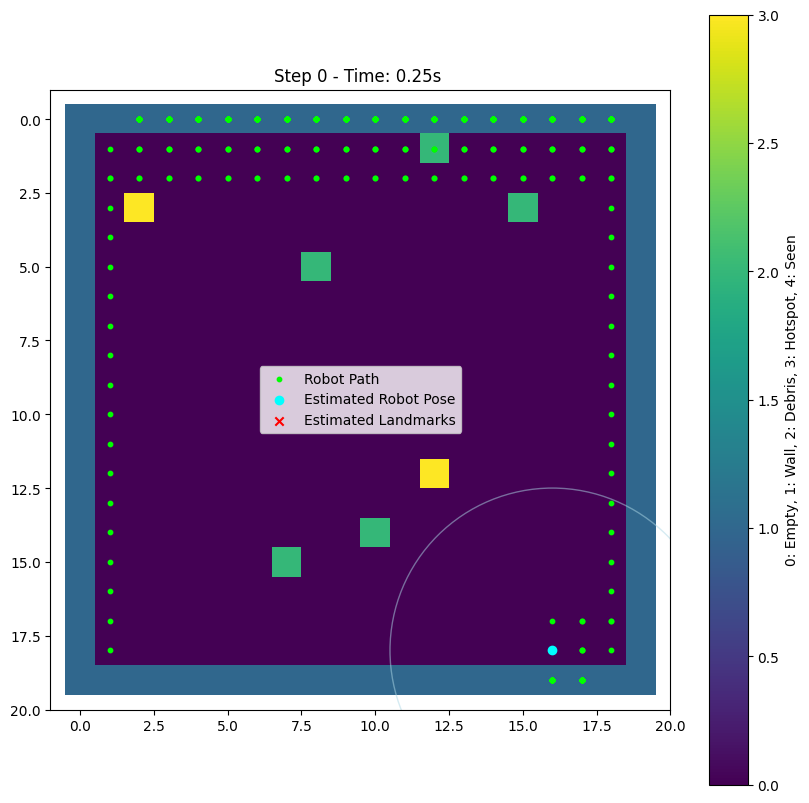

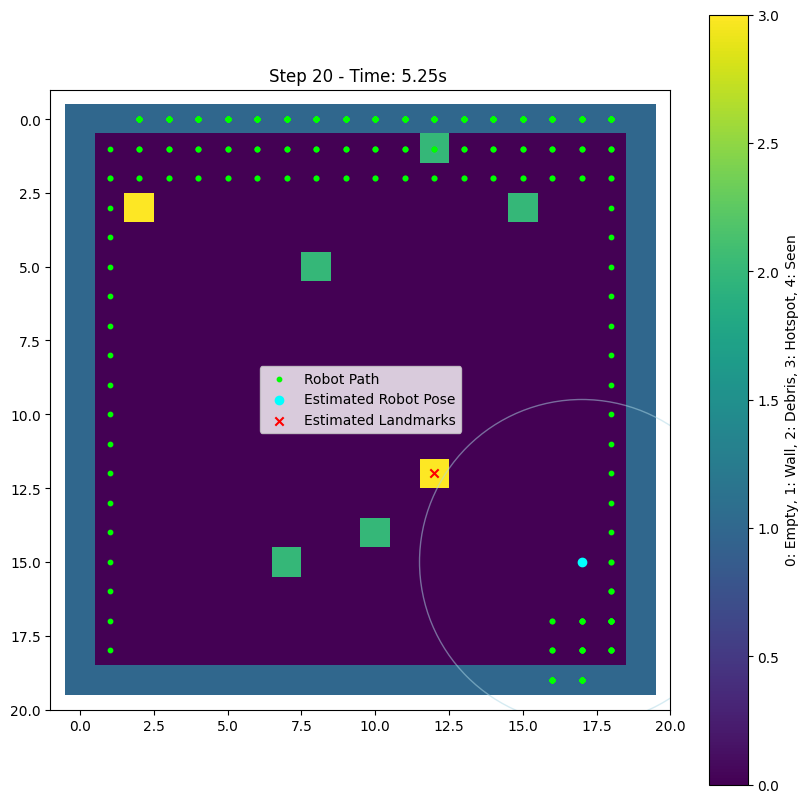

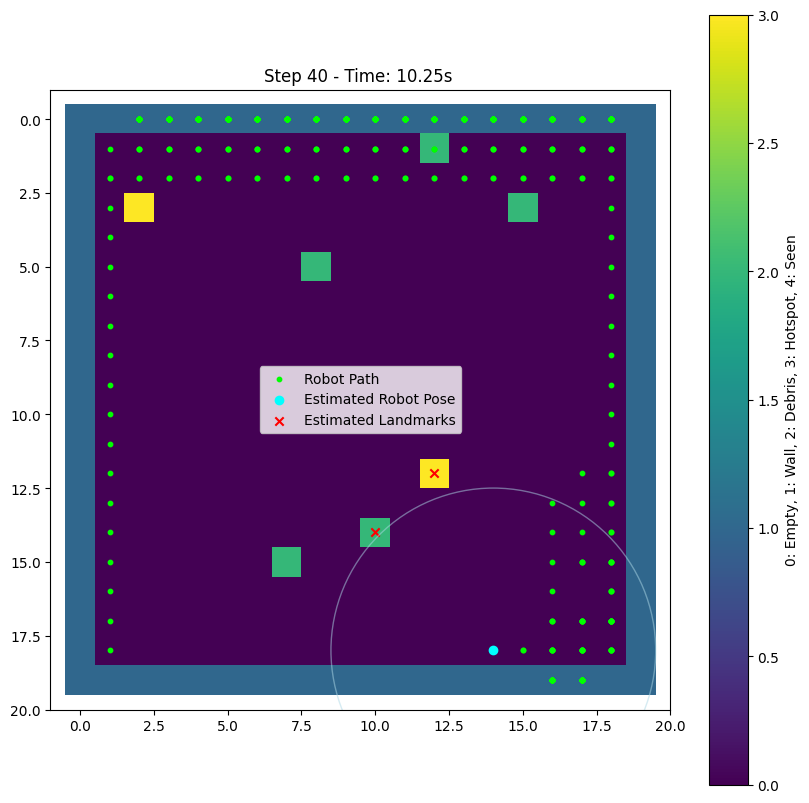

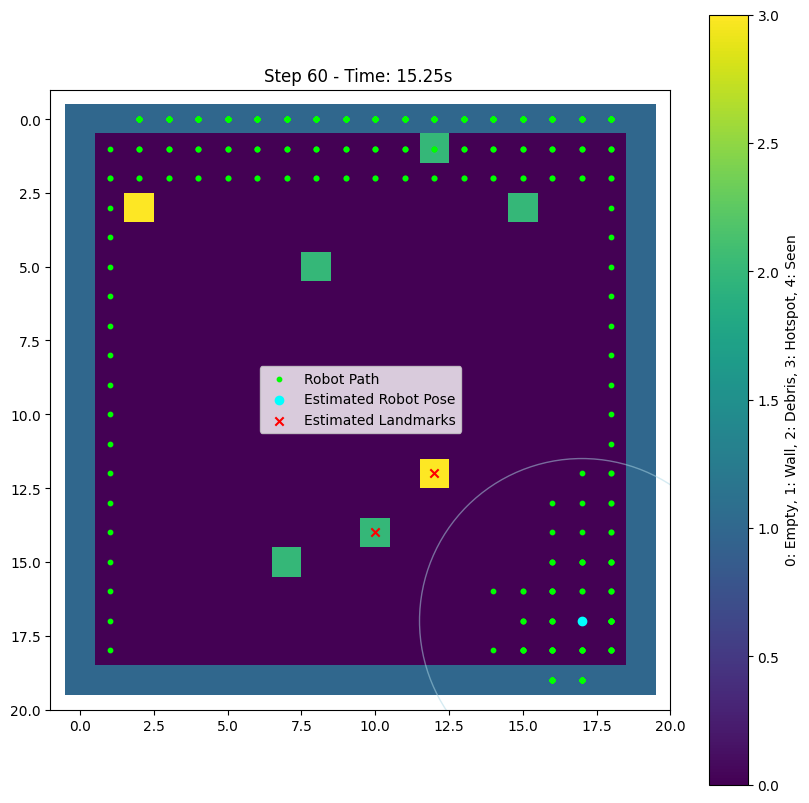

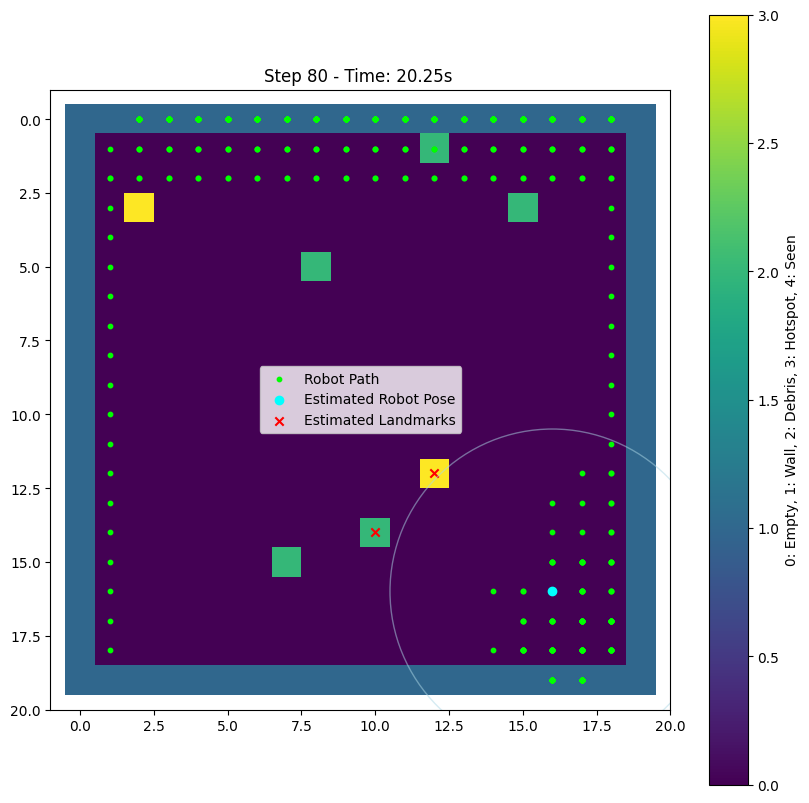

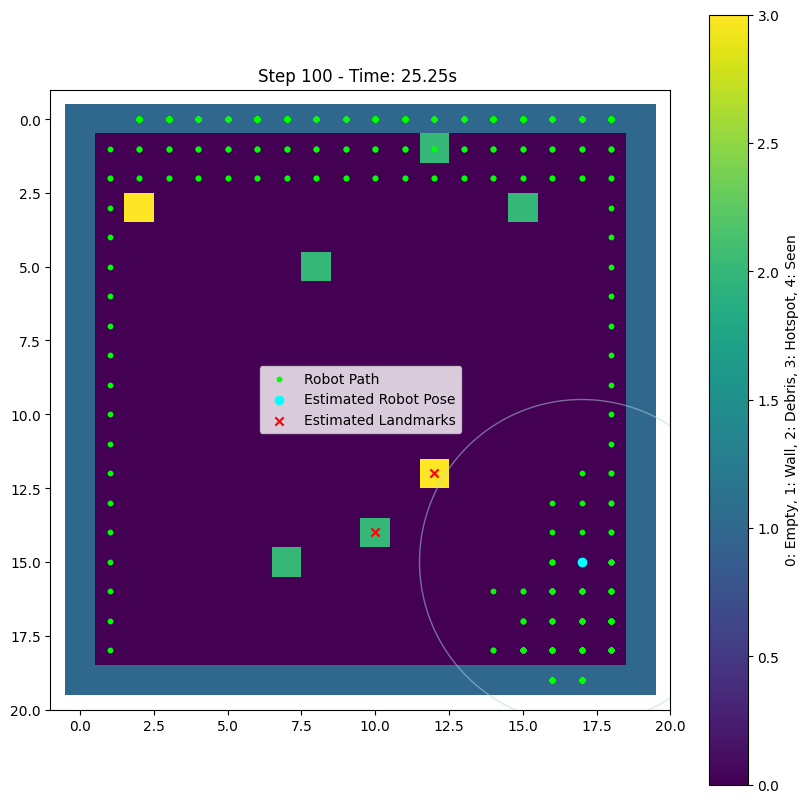

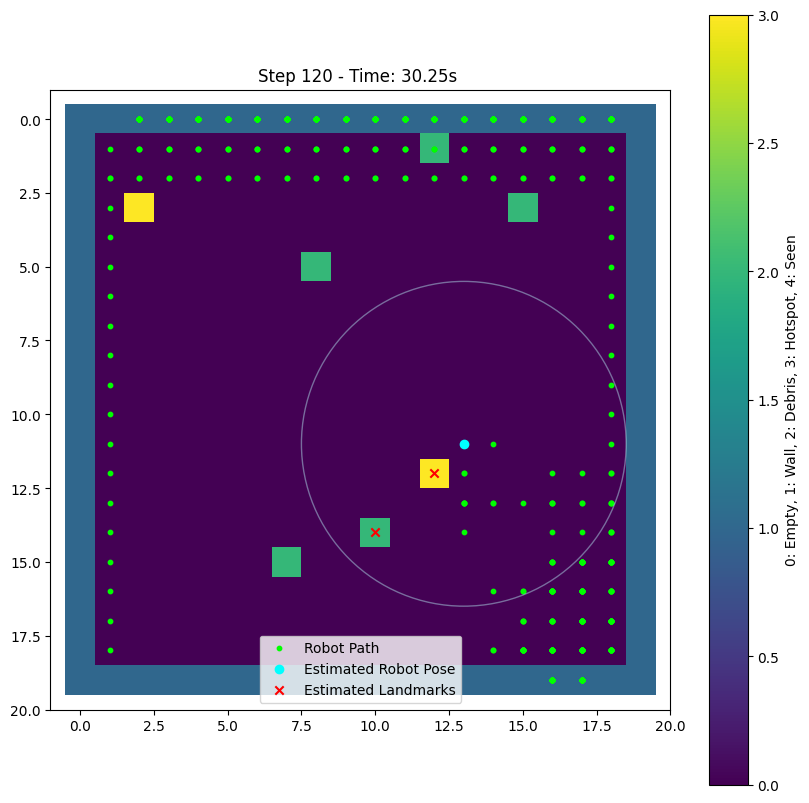

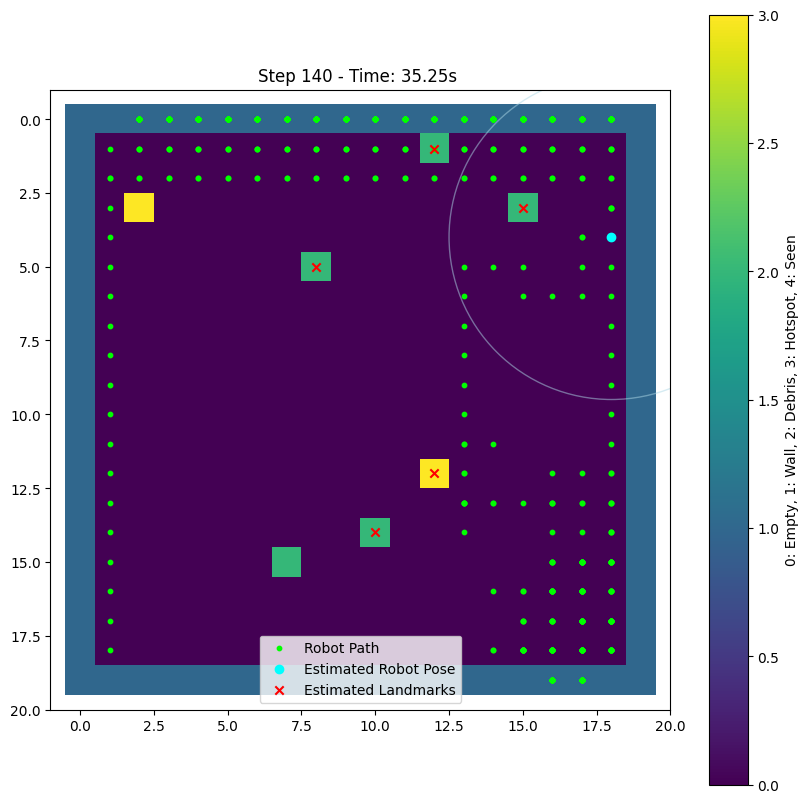

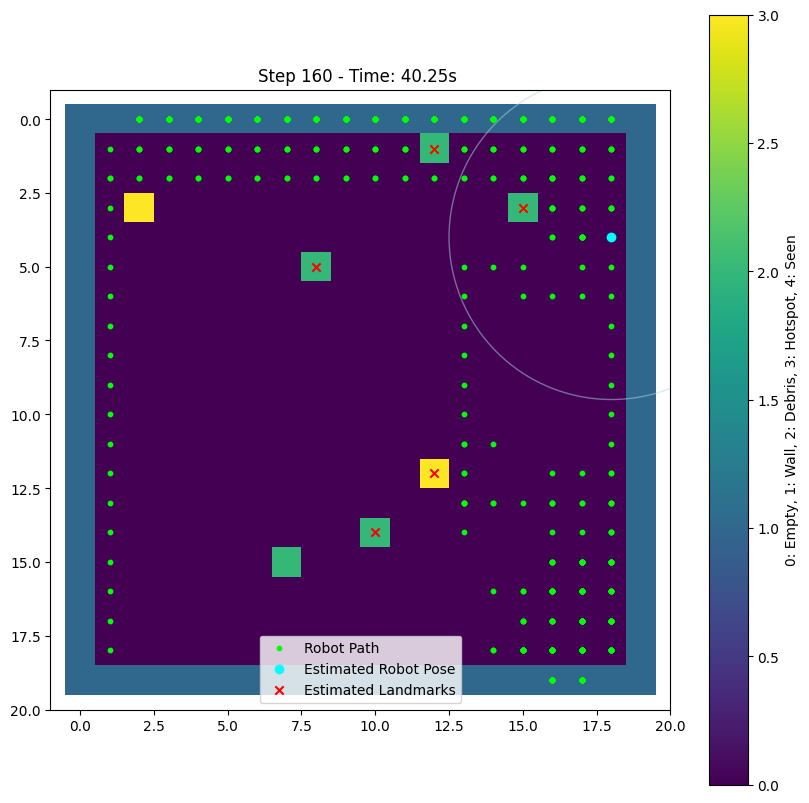

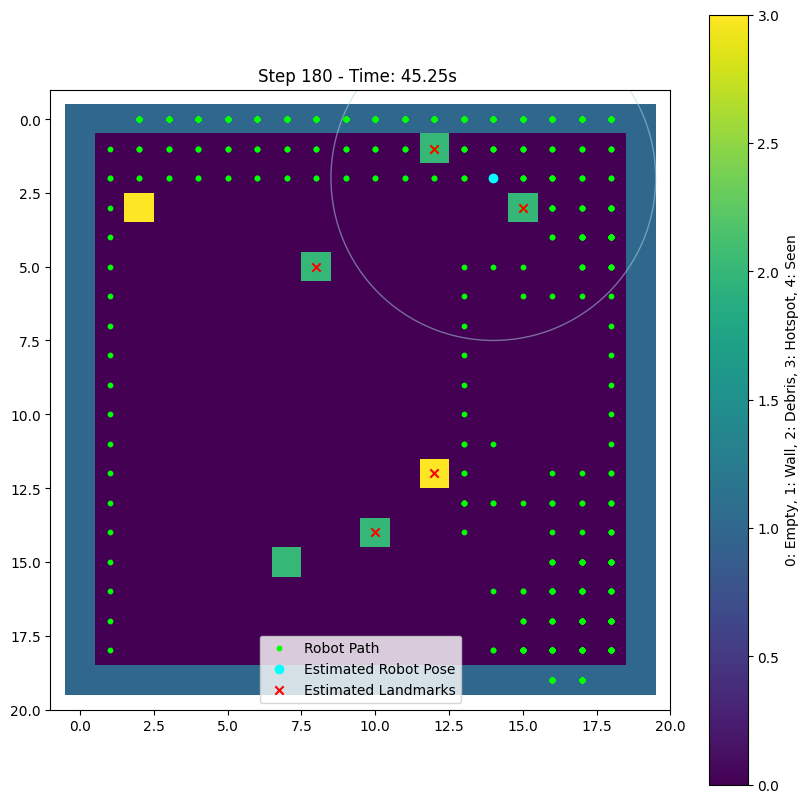

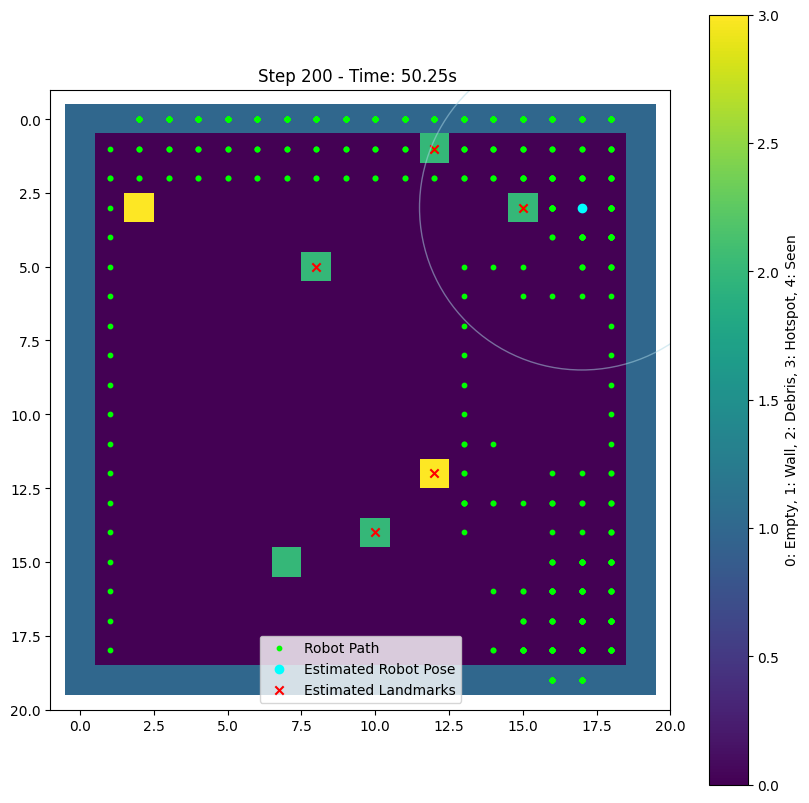

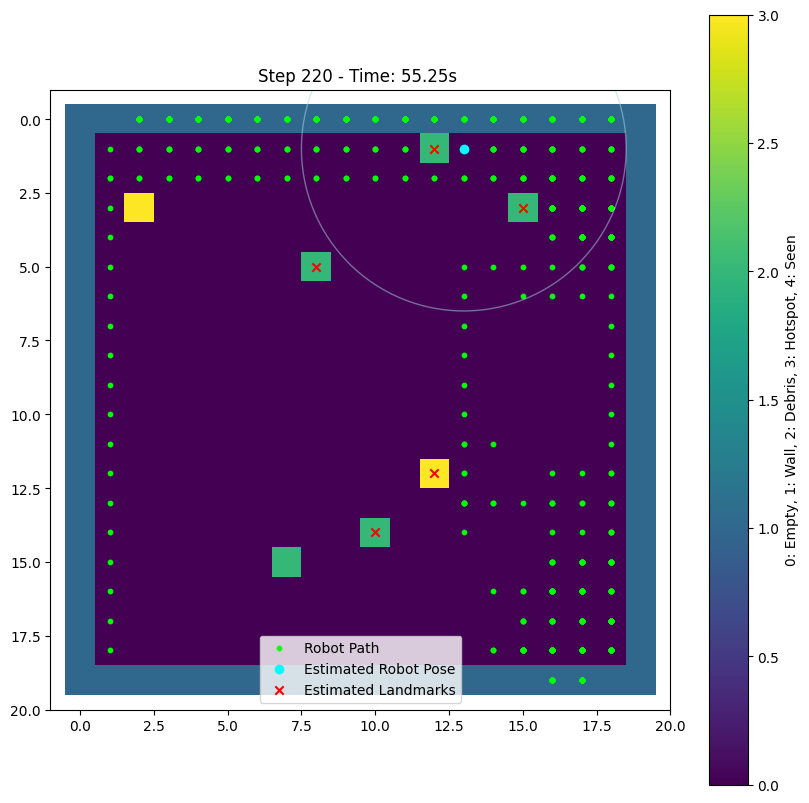

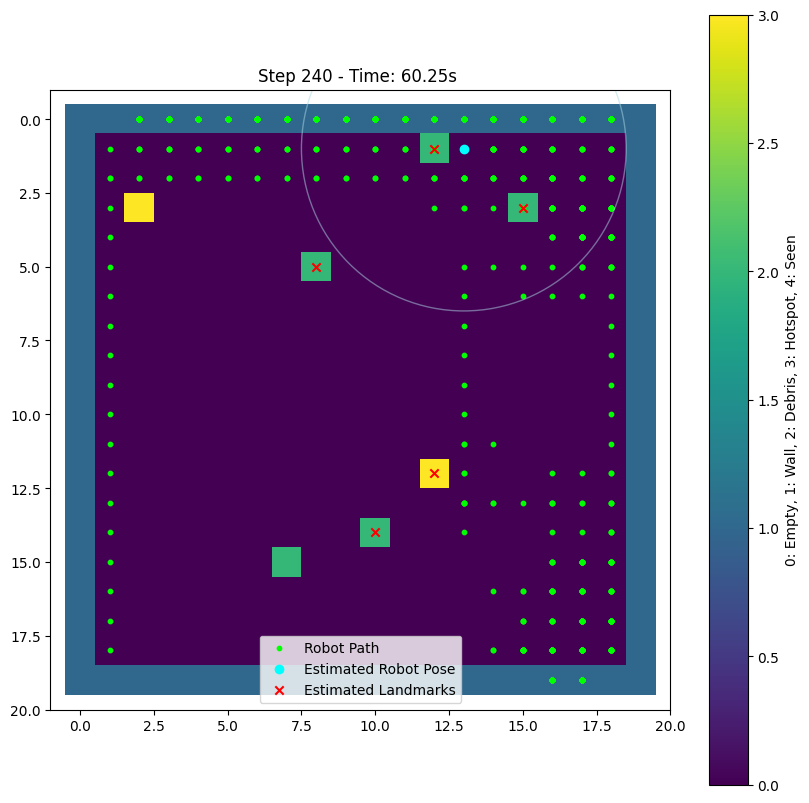

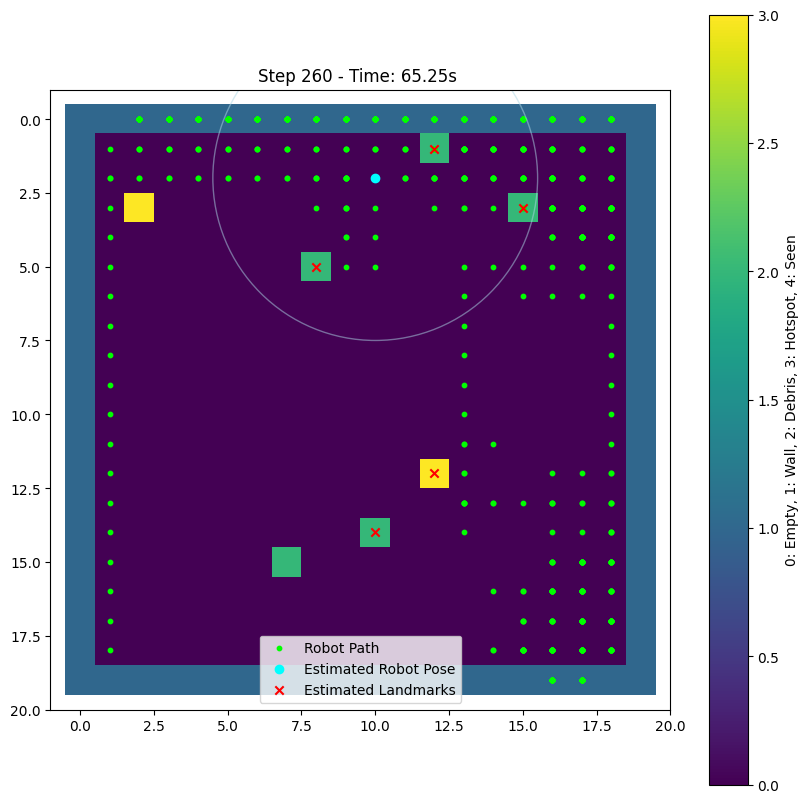

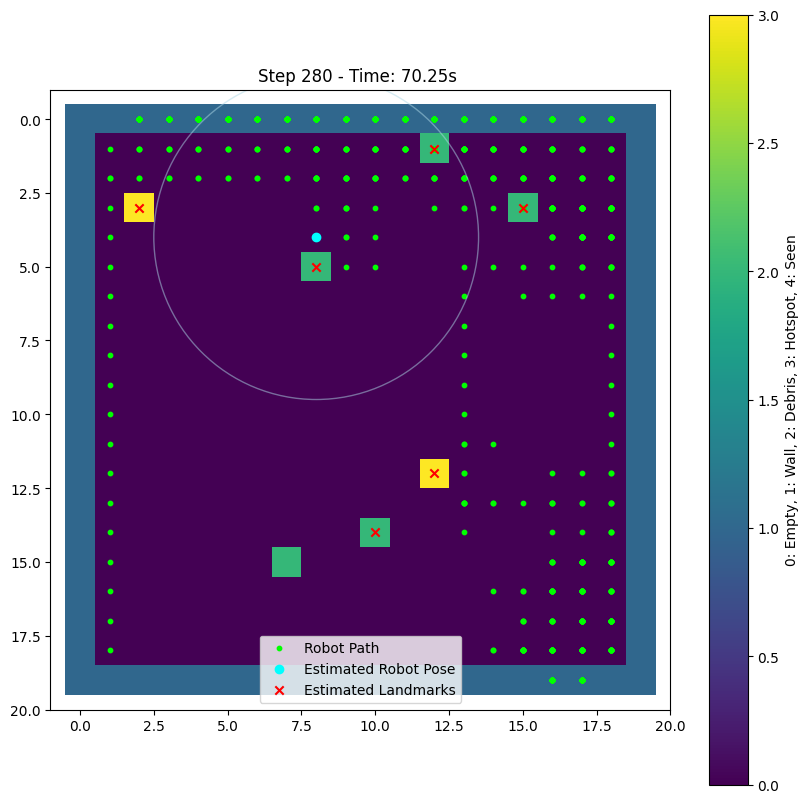

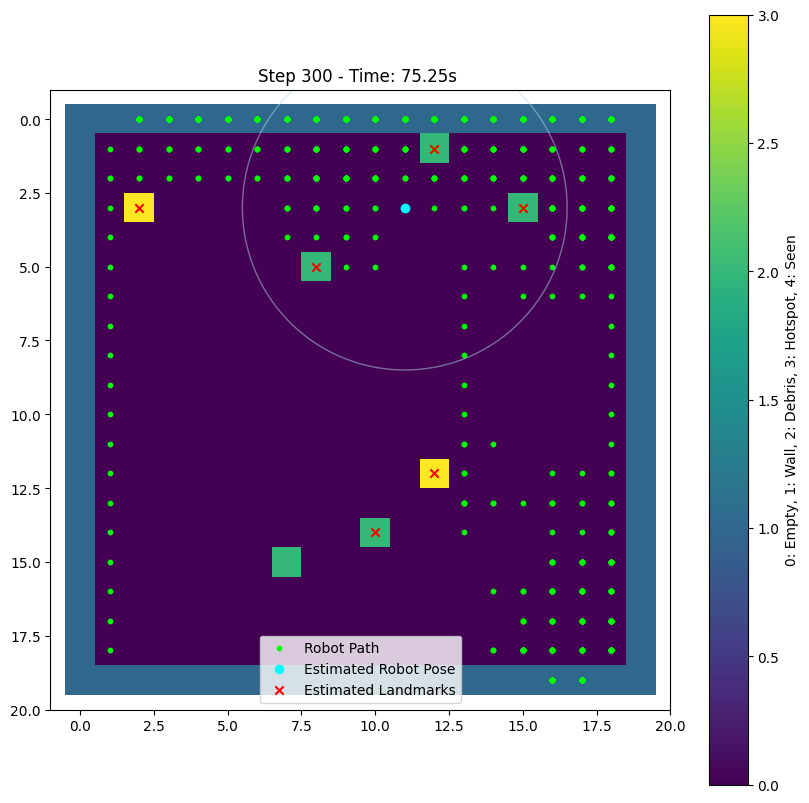

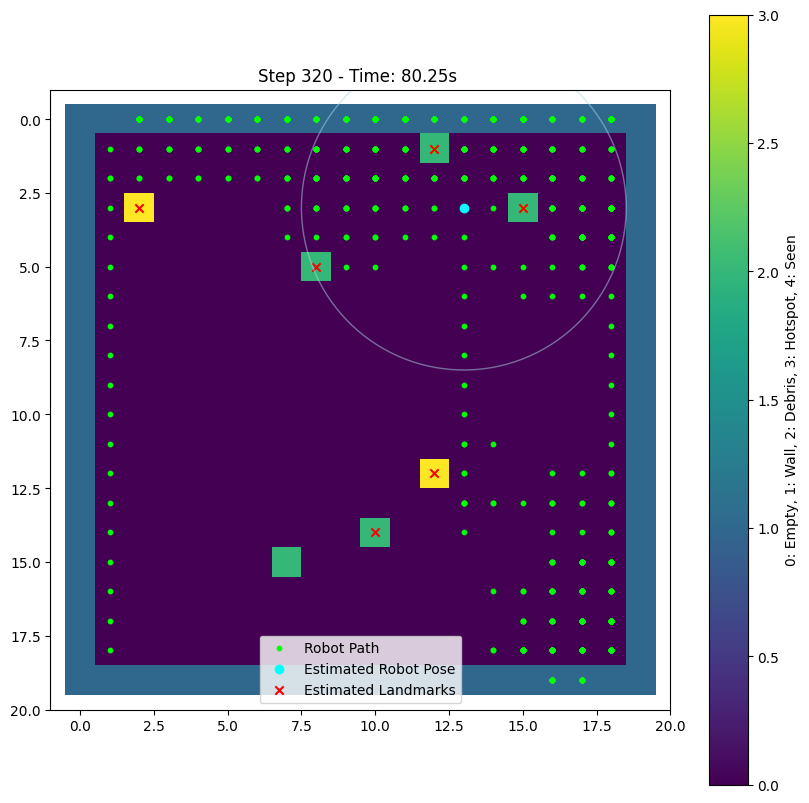

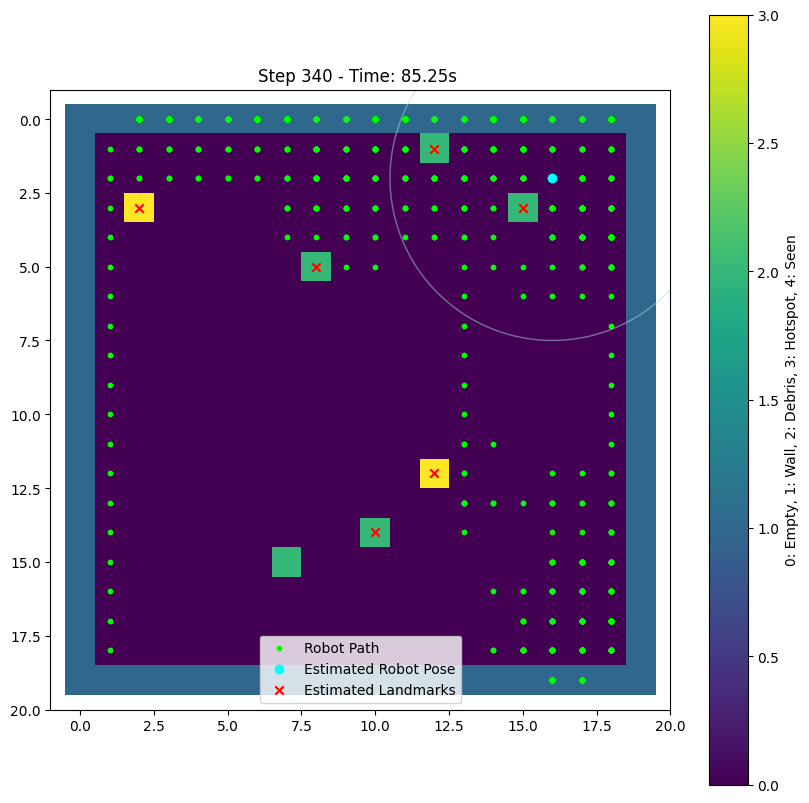

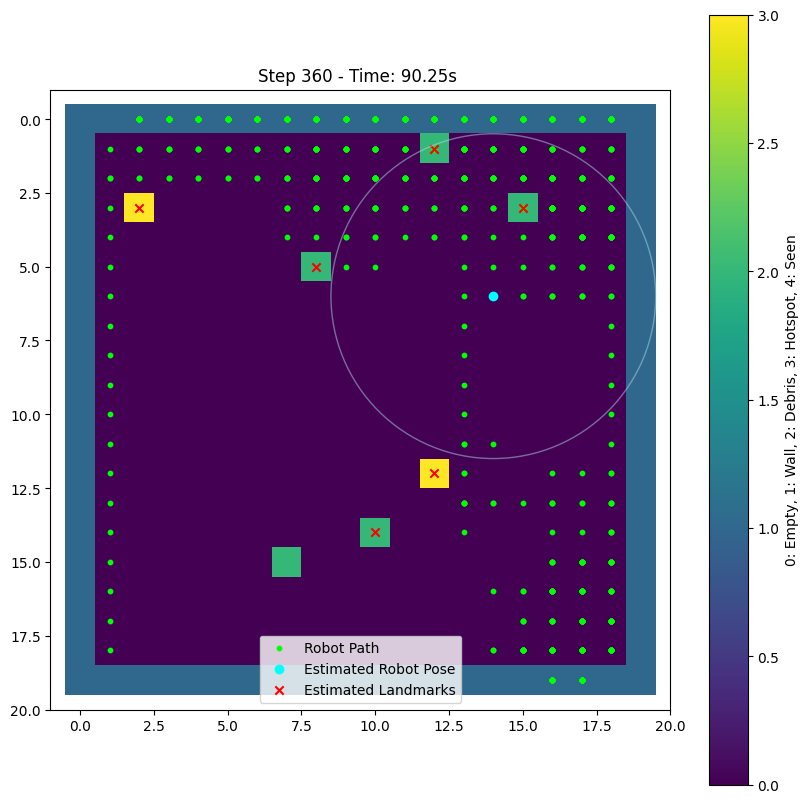

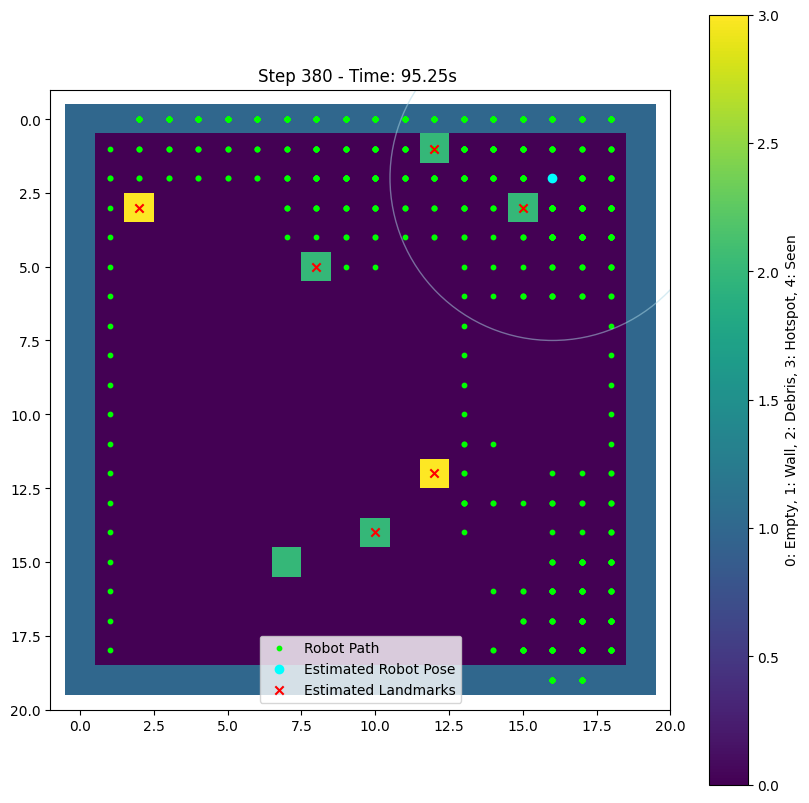

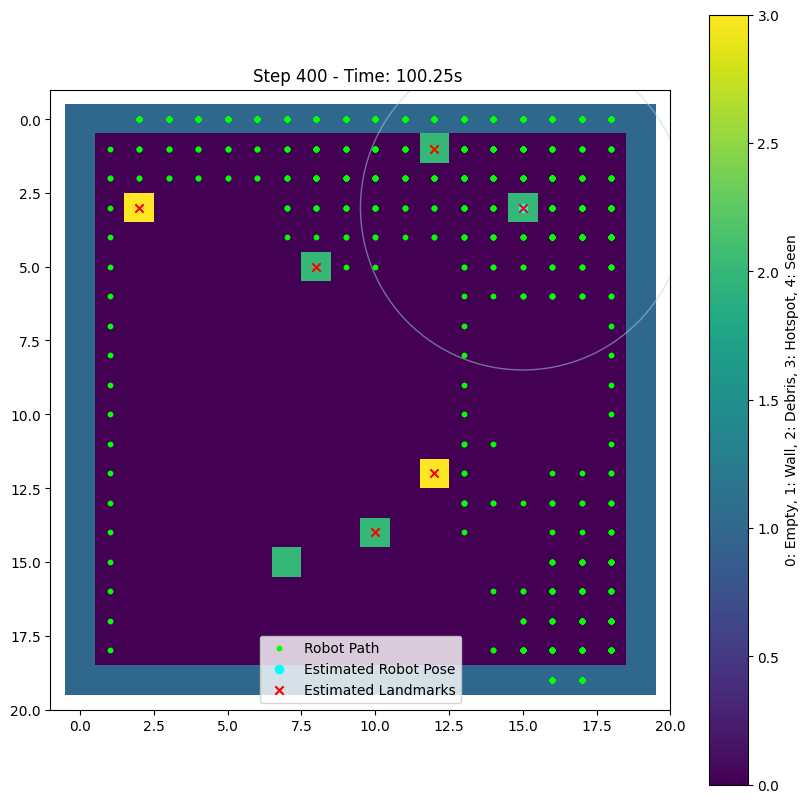

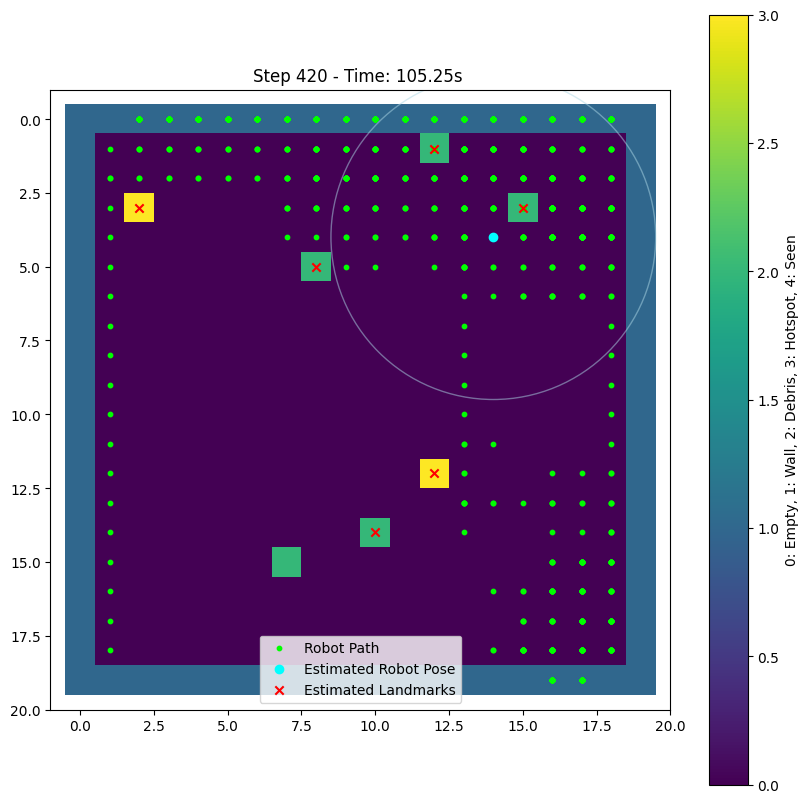

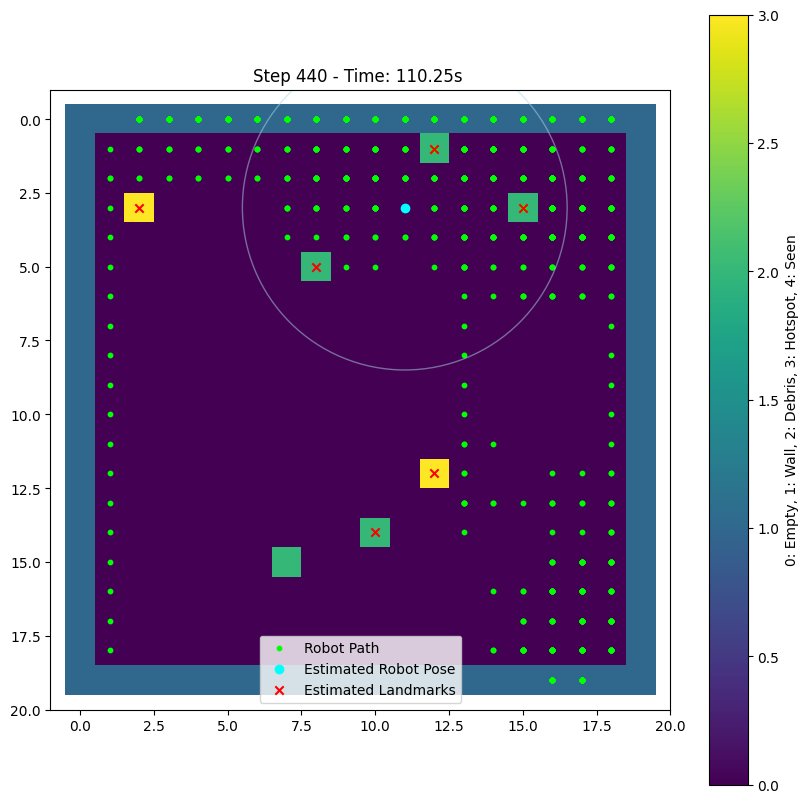

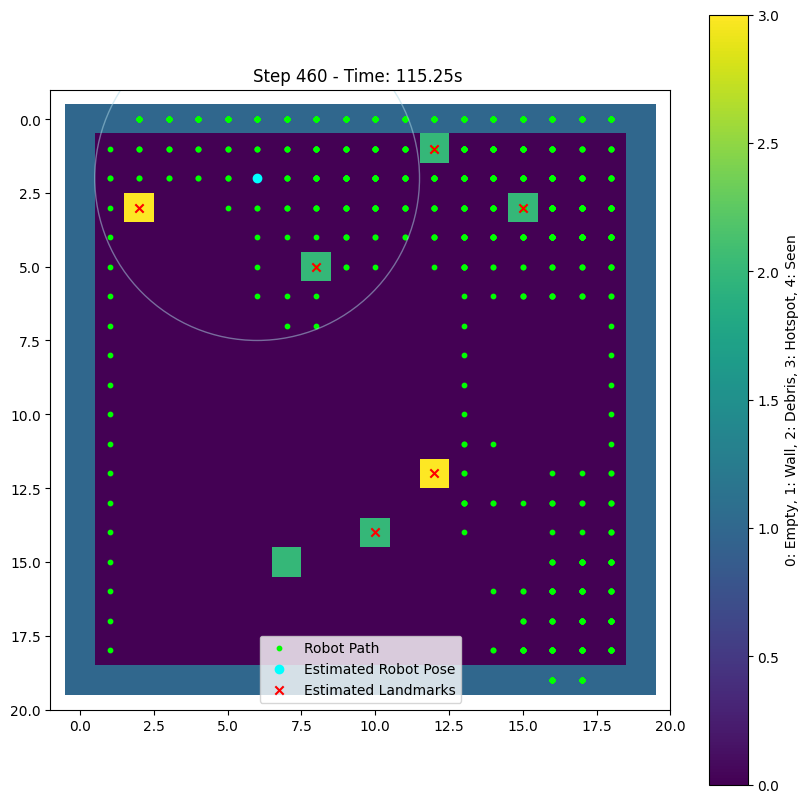

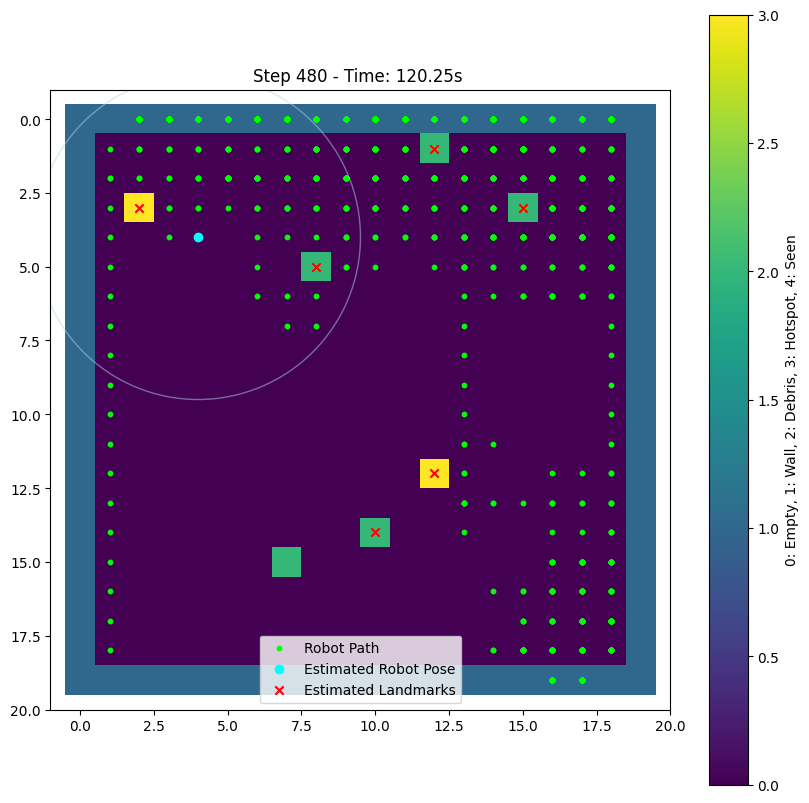

Robot did not fully map the room within the simulation steps.


In [4]:
### Simulation Run

elapsed_time = 0.0
mapping_complete = False
completion_time = None
mapped_coverage = np.zeros_like(grid, dtype=bool) # To track which cells are mapped
recent_path = []


for i in range(num_steps):
    if not mapping_complete:
        current_pos_list = robot_pos.flatten().tolist()
        # 1. Movement (Wall Following with Memory)
        move, robot_orientation = perform_movement_wall_follow(current_pos_list, grid, robot_orientation, recent_path, memory_length)
        robot_pos += np.array(move).reshape(2, 1)
        robot_path.append(robot_pos.flatten().tolist())

        # Update recent path
        recent_path.append(robot_pos.flatten().tolist())
        if len(recent_path) > memory_length:
            recent_path.pop(0)

        robot_pos_pred, robot_cov_pred = predict_step(robot_pos, robot_cov, move)

for i in range(num_steps):
    if not mapping_complete:
        # 1. Movement
        control = perform_movement(robot_pos.flatten().tolist(), grid)
        robot_path.append((robot_pos[0, 0] + control[0], robot_pos[1, 0] + control[1]))
        robot_pos_pred, robot_cov_pred = predict_step(robot_pos, robot_cov, control)

        # 2. Sensing with FOV
        observations = sense_environment(robot_pos_pred, grid, fov_radius)

        # 3. Update
        robot_pos, robot_cov, landmarks, new_landmarks = update_step(robot_pos_pred, robot_cov_pred, observations, landmarks)

        # Update mapped coverage
        row_r_est, col_r_est = np.round(robot_pos).astype(int).flatten()
        for dr in range(-fov_radius, fov_radius + 1):
            for dc in range(-fov_radius, fov_radius + 1):
                row_m, col_m = row_r_est + dr, col_r_est + dc
                if 0 <= row_m < mapped_grid.shape[0] and 0 <= col_m < mapped_grid.shape[1] and grid[row_m, col_m] != 1:
                    mapped_coverage[row_m, col_m] = True

        # Increment time
        elapsed_time += time_per_step

# Define a tolerance radius for visiting targets
    tolerance_radius = 1

    # Check if mapping is complete
    all_targets_visited = True
    for target in target_locations:
        visited = False
        for path_point in robot_path:
            distance = math.sqrt((target[0] - path_point[0])**2 + (target[1] - path_point[1])**2)
            if distance <= tolerance_radius:
                visited = True
                break
        if not visited:
            all_targets_visited = False
            break

    if all_targets_visited and not mapping_complete:
        mapping_complete = True
        completion_time = elapsed_time
        print(f"Mapping complete in {completion_time:.2f} seconds.")
        break

    # Visualization (every few steps)
    if i % 20 == 0: # Reduced frequency for longer run
        plt.figure(figsize=(10, 10))
        plt.imshow(mapped_grid)
        plt.title(f"Step {i} - Time: {elapsed_time:.2f}s {'(Mapping Complete!)' if mapping_complete else ''}")
        plt.colorbar(label="0: Empty, 1: Wall, 2: Debris, 3: Hotspot, 4: Seen")
        plt.scatter([p[1] for p in robot_path], [p[0] for p in robot_path], color='lime', s=10, label='Robot Path')
        plt.scatter(robot_pos[1], robot_pos[0], color='cyan', marker='o', label='Estimated Robot Pose')

        landmark_x = [lm['pos'][0, 0] for lm in landmarks.values()]
        landmark_y = [lm['pos'][1, 0] for lm in landmarks.values()]
        plt.scatter(landmark_x, landmark_y, color='red', marker='x', label='Estimated Landmarks')

        fov_circle = plt.Circle((robot_pos[1, 0], robot_pos[0, 0]), fov_radius + 0.5, color='lightblue', fill=False, alpha=0.5, linewidth=1)
        plt.gca().add_patch(fov_circle)

        plt.legend()
        plt.xlim(-1, grid_cols)
        plt.ylim(-1, grid_rows)
        plt.gca().invert_yaxis()
        plt.show()

if completion_time is None:
    print("Robot did not fully map the room within the simulation steps.")
elif completion_time is not None:
    print(f"Final mapping time: {completion_time:.2f} seconds.")